In [1]:
import numpy as np
import pandas as pd

# Preprocess datas

Human-Resource-Analytics-Kaggle-Dataset is a dataset with professionnal informations of employees. The objective is to unerstand if/why someone leave a company. https://github.com/ryankarlos/Human-Resource-Analytics-Kaggle-Dataset

In [2]:
hr = pd.read_csv('./datasets/HR_comma_sep.csv')
Xt = hr.drop(labels=['sales', 'salary', 'left'], axis=1)
X = (Xt-Xt.min())/(Xt.max()-Xt.min())
X = np.array(X)
X[np.isnan(X)] = -1
y = np.array(hr['left'])
y = y.astype(np.int).reshape(-1,1)
n_class = 2
n_features = len(Xt.columns)
Xt.shape, y.shape

((14999, 7), (14999, 1))

Audit Data is a dataset with audit score and risks factors. The objective is to understand if/why a company is fraudulent.
https://www.kaggle.com/sid321axn/audit-data

Bank_Loan_Classification is a dataset with banking informations of clients. Our objective is understand if/why someone doesn't have a loan.
https://www.kaggle.com/sriharipramod/bank-loan-classification

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7499, 7), (7500, 7), (7499, 1), (7500, 1))

# Train XGBoost model

In [5]:
import xgboost as xgb

In [6]:
dtrain = xgb.DMatrix(X_train.copy(), y_train.copy(), missing=np.nan)
dtest = xgb.DMatrix(X_test.copy(), y_test.copy(), missing=np.nan)


lmda = 2.0
params = {
    "objective":"multi:softprob", 
    'num_class': len(np.unique(y)), 
    'silent': 1, 
    'eval_metric': 'merror', 
    'base_score':0, 
    "lambda":lmda, 
    'max_depth': 4
}
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
best_iteration = 50

bst = xgb.train(params, dtrain, best_iteration, watchlist)

[0]	eval-merror:0.033733	train-merror:0.028537
[1]	eval-merror:0.031867	train-merror:0.024803
[2]	eval-merror:0.031333	train-merror:0.02387
[3]	eval-merror:0.0296	train-merror:0.022936
[4]	eval-merror:0.0328	train-merror:0.024937
[5]	eval-merror:0.0304	train-merror:0.022936
[6]	eval-merror:0.0316	train-merror:0.02387
[7]	eval-merror:0.030533	train-merror:0.023203
[8]	eval-merror:0.031467	train-merror:0.023603
[9]	eval-merror:0.031333	train-merror:0.02347
[10]	eval-merror:0.0304	train-merror:0.023336
[11]	eval-merror:0.031067	train-merror:0.023336
[12]	eval-merror:0.0312	train-merror:0.023203
[13]	eval-merror:0.030933	train-merror:0.022803
[14]	eval-merror:0.030267	train-merror:0.022003
[15]	eval-merror:0.029067	train-merror:0.022003
[16]	eval-merror:0.028	train-merror:0.02187
[17]	eval-merror:0.028133	train-merror:0.020803
[18]	eval-merror:0.0284	train-merror:0.020669
[19]	eval-merror:0.028533	train-merror:0.020269
[20]	eval-merror:0.027733	train-merror:0.020403
[21]	eval-merror:0.0276

In [7]:
from sklearn.metrics import accuracy_score

In [8]:
pred = bst.predict(dtest)
accuracy_score(pred.argmax(axis=1), y_test)

0.9754666666666667

In [9]:
from sklearn.preprocessing import OneHotEncoder

In [10]:
y_train = OneHotEncoder(categories='auto').fit_transform(y_train).toarray()
y_test = OneHotEncoder(categories='auto').fit_transform(y_test).toarray()

# Build DFE model

In [13]:
from estimators.dfe import DFE
import torch
device = torch.device("cpu")

In [14]:
dfe = DFE(bst, n_class=n_class, n_features=n_features, alpha=10e2, device=device)
dfe.fit(X_train.copy(), y_train.copy(), X_val=X_test.copy(), Y_val=y_test.copy())

In [15]:
bmodel = dfe.get_model()

# Performances

In [16]:
from scipy.special import softmax

In [17]:
p0 = softmax(bst.predict(dtest, output_margin=True))
p1 = softmax(dfe.predict(X_test, softmax=False), axis=1)
p2 = softmax(dfe.predict_model(bst, X_test))

In [18]:
p0 = softmax(bst.predict(dtest, output_margin=True))

p0p1 = []

x = 10**((np.arange(10)/1)-3)
for i in x:
    dfe_i = DFE(bst, n_class=n_class, n_features=n_features, alpha=i, device=device)
    dfe_i.fit(X_train.copy(), y_train.copy(), X_val=X_test.copy(), Y_val=y_test.copy())
    p1 = softmax(dfe_i.predict(X_test, softmax=False))
    p0p1.append(accuracy_score(p0.argmax(1), p1.argmax(1)))
    del(dfe_i)

In [19]:
import matplotlib.pyplot as plt

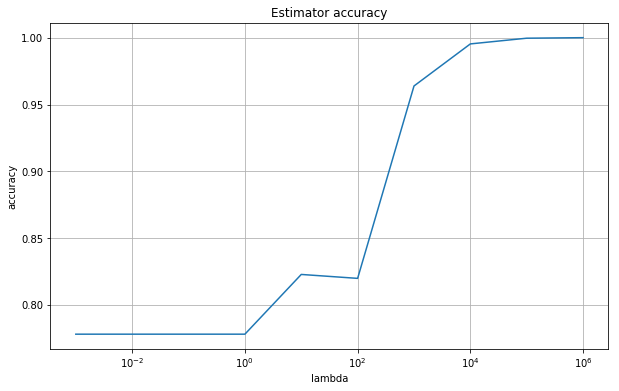

In [20]:
plt.figure(figsize=(10,6))
plt.plot(x, p0p1)
plt.xscale('log')
plt.grid(which='both')
plt.title('Estimator accuracy')
plt.ylabel('accuracy')
plt.xlabel('lambda')
plt.show()

# Select faulty example

In [21]:
pred_test = torch.argmax(bmodel(torch.tensor(X_test), training=False), dim=1).data.numpy()
Y_test = np.argmax(y_test, axis=1)
FC_index = np.logical_and(pred_test==Y_test,Y_test==1)
FC_X = X_test[FC_index]
FC_Y = Y_test[FC_index]
sample_idx = np.random.choice(range(len(FC_X)))
x = FC_X[sample_idx]
y = 0

# Search partenarial example

In [22]:
from example_research.ddn import DDN
import torch.nn as nn

Loss = nn.CrossEntropyLoss(reduction='mean')
ddn = DDN(bmodel, Loss, alpha=1, gamma=0.05)
xa = ddn.fit(x, y, n_iter=100)

y=tensor([[0.3187, 0.2188, 0.0000, 0.1682, 0.1250, 0.0000, 0.0000]],
       dtype=torch.float64), target=[0], m=-1, out=[[-0.67452234  0.6745227 ]]
Epoch 0 - OUT - distance: 1.05
Epoch 1 - IN  - distance: 0.9974999999999999
Epoch 2 - IN  - distance: 0.9476249999999999
Epoch 3 - IN  - distance: 0.9002437499999999
Epoch 4 - IN  - distance: 0.8552315624999998
Epoch 5 - IN  - distance: 0.812469984375
Epoch 6 - IN  - distance: 0.7718464851562498
Epoch 7 - IN  - distance: 0.7332541608984371
Epoch 8 - IN  - distance: 0.6965914528535154
Epoch 9 - IN  - distance: 0.6617618802108395
Epoch 10 - IN  - distance: 0.6286737862002975
Epoch 11 - IN  - distance: 0.5972400968902826
Epoch 12 - IN  - distance: 0.5673780920457684
Epoch 13 - IN  - distance: 0.5390091874434799
Epoch 14 - IN  - distance: 0.512058728071306
Epoch 15 - IN  - distance: 0.4864557916677406
Epoch 16 - IN  - distance: 0.46213300208435354
Epoch 17 - IN  - distance: 0.4390263519801359
Epoch 18 - IN  - distance: 0.41707503438112903
Epoch

# Results

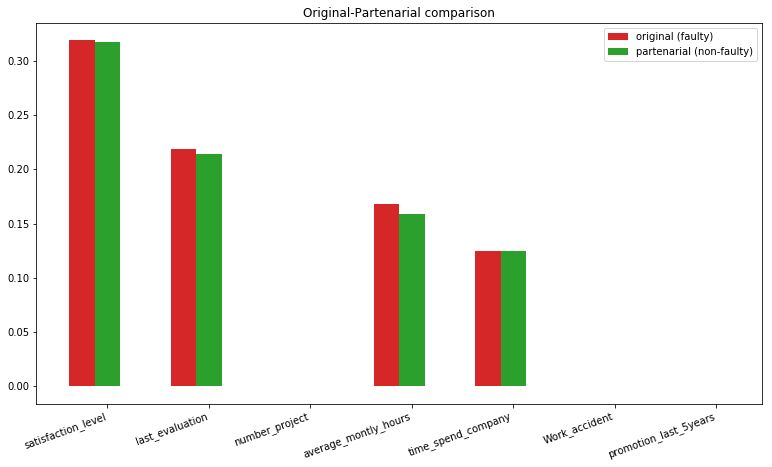

In [23]:
col_idx = np.array(list(range(xa[-1].size(1))))
xadv = xa[-1][0].data.numpy()
width = 0.25

plt.figure(figsize=(13,7))

plt.bar(col_idx-width/2, x, width, tick_label=Xt.columns, label='original (faulty)', color='tab:red')
plt.xticks(rotation=20, ha='right')

plt.bar(col_idx+width/2, xadv, width, tick_label=Xt.columns, label='partenarial (non-faulty)', color='tab:green')
plt.xticks(rotation=20, ha='right')

plt.legend()
plt.title('Original-Partenarial comparison')
plt.show()